# Analyse du data

In [1]:
# Imports PySpark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Initialisation de la session Spark
spark = SparkSession.builder \
    .appName("BTC_Silver") \
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/01/20 12:03:08 WARN Utils: Your hostname, DESKTOP-A9FN519, resolves to a loopback address: 127.0.1.1; using 172.30.212.146 instead (on interface eth0)
26/01/20 12:03:08 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/20 12:03:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


26/01/20 14:13:24 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 4404683 ms exceeds timeout 120000 ms
26/01/20 14:13:24 WARN SparkContext: Killing executors is not supported by current scheduler.
26/01/20 14:13:26 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:53)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:359)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:132)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$

In [3]:
# Lecture du fichier Parquet Bronze
bronze_path = "/mnt/c/Users/hp/desktop/BTC-End2End-Platform/ml/data/bronze/btc_minute_data.parquet"
df_bronze = spark.read.parquet(bronze_path)

# Afficher un aperçu
df_bronze.show(5)


+-------------------+--------+--------+--------+--------+-------+--------------------+------------------+----------------+---------------------+----------------------+------+
|          open_time|    open|    high|     low|   close| volume|          close_time|quote_asset_volume|number_of_trades|taker_buy_base_volume|taker_buy_quote_volume|ignore|
+-------------------+--------+--------+--------+--------+-------+--------------------+------------------+----------------+---------------------+----------------------+------+
|2026-01-19 09:53:00|93046.35|93046.35|92997.65| 93001.8|9.10532|2026-01-19 09:53:...|    847027.2616431|            2024|              2.08878|        194272.7849138|     0|
|2026-01-19 09:54:00| 93001.8|93022.23|93001.79|93014.94|5.62556|2026-01-19 09:54:...|    523245.8306426|            1064|              3.42885|        318907.7899883|     0|
|2026-01-19 09:55:00|93014.95|93042.27|93014.95|93022.36|3.74306|2026-01-19 09:55:...|    348227.1952126|            1863|   

In [4]:
df_bronze.printSchema()

root
 |-- open_time: timestamp_ntz (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- volume: double (nullable = true)
 |-- close_time: timestamp_ntz (nullable = true)
 |-- quote_asset_volume: double (nullable = true)
 |-- number_of_trades: long (nullable = true)
 |-- taker_buy_base_volume: double (nullable = true)
 |-- taker_buy_quote_volume: double (nullable = true)
 |-- ignore: string (nullable = true)



In [5]:
df_bronze.columns

['open_time',
 'open',
 'high',
 'low',
 'close',
 'volume',
 'close_time',
 'quote_asset_volume',
 'number_of_trades',
 'taker_buy_base_volume',
 'taker_buy_quote_volume',
 'ignore']

In [6]:
df_bronze.describe().show()

26/01/19 21:32:57 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+---------------------+----------------------+------+
|summary|              open|              high|               low|             close|           volume|quote_asset_volume|  number_of_trades|taker_buy_base_volume|taker_buy_quote_volume|ignore|
+-------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+---------------------+----------------------+------+
|  count|               600|               600|               600|               600|              600|               600|               600|                  600|                   600|   600|
|   mean| 93070.08556666668| 93084.20378333335| 93055.98494999995|  93070.1422166667|5.902528833333327| 549296.6430280326|1694.1466666666668|    2.621530233333333|     243988.0310935778|   0.0|
| stddev|119.90986944226844|11

In [7]:
from pyspark.sql.functions import col, sum as spark_sum, when
df_bronze.select([
    spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
      for c in df_bronze.columns
      ]).show()

+---------+----+----+---+-----+------+----------+------------------+----------------+---------------------+----------------------+------+
|open_time|open|high|low|close|volume|close_time|quote_asset_volume|number_of_trades|taker_buy_base_volume|taker_buy_quote_volume|ignore|
+---------+----+----+---+-----+------+----------+------------------+----------------+---------------------+----------------------+------+
|        0|   0|   0|  0|    0|     0|         0|                 0|               0|                    0|                     0|     0|
+---------+----+----+---+-----+------+----------+------------------+----------------+---------------------+----------------------+------+



In [8]:
print("Nombres des lingne:", df_bronze.count())

Nombres des lingne: 600


In [9]:
uniques_lignes = df_bronze.dropDuplicates().count()
print(f"Nombre de lignes uniques :{uniques_lignes}")

Nombre de lignes uniques :600


In [ ]:
# Type casting pour colonnes numeriques
df_bronze = df_bronze.withColumn("close", F.col("close").cast("double")) \
       .withColumn("volume", F.col("volume").cast("double")) \
       .withColumn("taker_buy_base_volume", F.col("taker_buy_base_volume").cast("double"))

df_bronze.printSchema()


root
 |-- open_time: timestamp_ntz (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- volume: double (nullable = true)
 |-- close_time: timestamp_ntz (nullable = true)
 |-- quote_asset_volume: double (nullable = true)
 |-- number_of_trades: long (nullable = true)
 |-- taker_buy_base_volume: double (nullable = true)
 |-- taker_buy_quote_volume: double (nullable = true)
 |-- ignore: string (nullable = true)



In [17]:
from pyspark.sql.window import Window
from pyspark.sql import functions as F

# Créer une fenêtre ordonnée par temps
window = Window.orderBy("open_time")

# Décaler la colonne 'close' de 10 lignes (10 minutes)
df_bronze = df_bronze.withColumn("close_t_plus_10", F.lead("close", 10).over(window))


In [18]:
# Définition de la fenêtre temporelle
window = Window.orderBy("open_time")

# Calcul des retours
df_bronze = df_bronze.withColumn(
    "return_1m",
    (F.col("close") - F.lag("close", 1).over(window)) / F.lag("close", 1).over(window)
)

df_bronze.select("open_time", "close", "return_1m").show(5)


26/01/19 22:26:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/19 22:26:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/19 22:26:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/19 22:26:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/19 22:26:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-------------------+--------+--------------------+
|          open_time|   close|           return_1m|
+-------------------+--------+--------------------+
|2026-01-19 09:53:00| 93001.8|                NULL|
|2026-01-19 09:54:00|93014.94|1.412875879821618...|
|2026-01-19 09:55:00|93022.36| 7.97721312296525E-5|
|2026-01-19 09:56:00|93019.77|-2.78427681258195...|
|2026-01-19 09:57:00|93016.23|-3.80564260695134...|
+-------------------+--------+--------------------+
only showing top 5 rows


In [19]:
# Definition des fenêtres temporelles
window_past = Window.orderBy("open_time")
ma5 = Window.orderBy("open_time").rowsBetween(-4, 0)
ma10 = Window.orderBy("open_time").rowsBetween(-9, 0)

# Calcul des indicateurs techniques
df_bronze = df_bronze.withColumn("ma_5", F.avg("close").over(ma5)) \
                     .withColumn("ma_10", F.avg("close").over(ma10)) \
                     .withColumn("taker_ratio", F.col("taker_buy_base_volume") / F.col("volume")) \
                     .withColumn("return_1m", (F.col("close") - F.lag("close", 1).over(window_past)) / F.lag("close", 1).over(window_past))

df_bronze = df_bronze.withColumn("close_t_plus_10", F.lead("close", 10).over(window_past))

df_bronze.select("open_time", "close", "ma_5", "taker_ratio", "return_1m", "close_t_plus_10").show(5)

26/01/19 22:26:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/19 22:26:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/19 22:26:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/19 22:26:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/19 22:26:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-------------------+--------+-----------------+-------------------+--------------------+---------------+
|          open_time|   close|             ma_5|        taker_ratio|           return_1m|close_t_plus_10|
+-------------------+--------+-----------------+-------------------+--------------------+---------------+
|2026-01-19 09:53:00| 93001.8|          93001.8|0.22940215170911069|                NULL|       92965.51|
|2026-01-19 09:54:00|93014.94|         93008.37| 0.6095126529625495|1.412875879821618...|       92975.79|
|2026-01-19 09:55:00|93022.36|93013.03333333333|0.31234604842027647| 7.97721312296525E-5|       92965.51|
|2026-01-19 09:56:00|93019.77|       93014.7175|0.12238646513573805|-2.78427681258195...|        92900.0|
|2026-01-19 09:57:00|93016.23|93015.01999999999| 0.7786267356587128|-3.80564260695134...|       92949.84|
+-------------------+--------+-----------------+-------------------+--------------------+---------------+
only showing top 5 rows


In [ ]:
# # Calcul du Taker Ratio
# df_bronze = df_bronze.withColumn(
#     "taker_ratio",
#     F.col("taker_buy_base_volume") / F.col("volume")
# )

# df_bronze.select("open_time", "taker_buy_base_volume", "volume", "taker_ratio").show(5)


# # Supprimer les lignes contenant des valeurs nulles générées par les fenêtres (MA, Lag, Lead)
# df_clean = df_bronze.dropna(subset=["return_1m", "ma_5", "ma_10", "taker_ratio", "close_t_plus_10"])

# print(f"Nombre de lignes après nettoyage : {df_clean.count()}")

+-------------------+---------------------+-------+-------------------+
|          open_time|taker_buy_base_volume| volume|        taker_ratio|
+-------------------+---------------------+-------+-------------------+
|2026-01-19 09:53:00|              2.08878|9.10532|0.22940215170911069|
|2026-01-19 09:54:00|              3.42885|5.62556| 0.6095126529625495|
|2026-01-19 09:55:00|              1.16913|3.74306|0.31234604842027647|
|2026-01-19 09:56:00|              0.84542|6.90779|0.12238646513573805|
|2026-01-19 09:57:00|              0.83665|1.07452| 0.7786267356587128|
+-------------------+---------------------+-------+-------------------+
only showing top 5 rows


# Visualisation


26/01/19 22:26:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/19 22:26:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/19 22:26:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/19 22:26:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/19 22:26:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


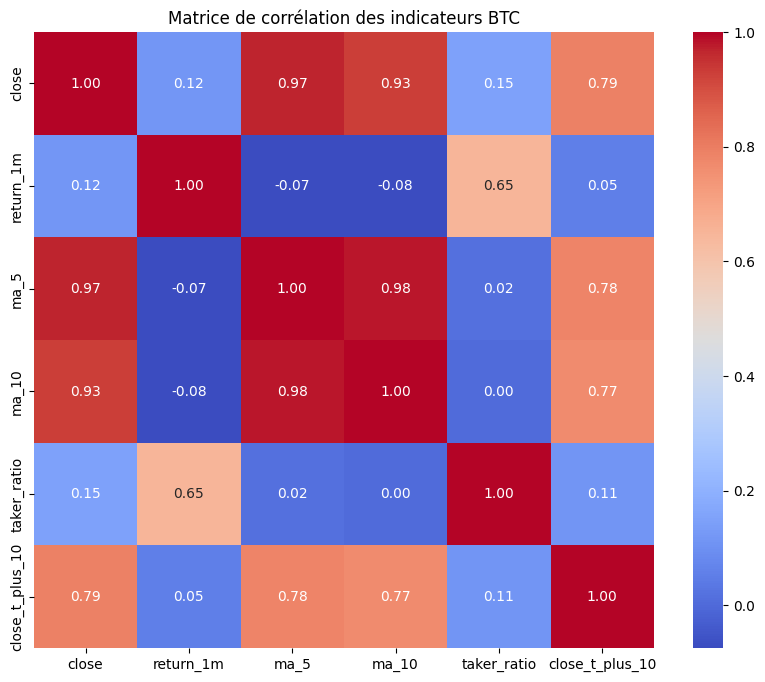

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sélection des colonnes numériques pour la corrélation
cols_to_corr = ["close", "return_1m", "ma_5", "ma_10", "taker_ratio", "close_t_plus_10"]
pdf = df_bronze.select(cols_to_corr).toPandas()

# Affichage de la matrice
plt.figure(figsize=(10, 8))
sns.heatmap(pdf.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice de corrélation des indicateurs BTC")
plt.show()

In [22]:
df_silver = df_bronze.drop("taker_ratio", "return_lm")
df_silver.show()

26/01/19 22:33:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/19 22:33:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/19 22:33:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/19 22:33:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/19 22:33:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-------------------+--------+--------+--------+--------+--------+--------------------+------------------+----------------+---------------------+----------------------+------+-----------------+-----------------+--------------------+---------------+
|          open_time|    open|    high|     low|   close|  volume|          close_time|quote_asset_volume|number_of_trades|taker_buy_base_volume|taker_buy_quote_volume|ignore|             ma_5|            ma_10|           return_1m|close_t_plus_10|
+-------------------+--------+--------+--------+--------+--------+--------------------+------------------+----------------+---------------------+----------------------+------+-----------------+-----------------+--------------------+---------------+
|2026-01-19 09:53:00|93046.35|93046.35|92997.65| 93001.8| 9.10532|2026-01-19 09:53:...|    847027.2616431|            2024|              2.08878|        194272.7849138|     0|          93001.8|          93001.8|                NULL|       92965.51|
|202

In [24]:
df_bronze.coalesce(1)\
    .write.mode("overwrite")\
    .parquet("/mnt/c/Users/hp/desktop/BTC-End2End-Platform/ml/data/silver/silver_dataset")


26/01/19 22:36:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/19 22:36:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/19 22:36:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/19 22:36:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/19 22:36:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
